<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/main/develop_simple_pulse_finder_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/benkrikler/wavefilter#egg=wavefilter"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter to /tmp/pip-install-ptfsx_t3/wavefilter_8aa9f10356884690891488c69aef4660
  Running command git clone -q https://github.com/benkrikler/wavefilter /tmp/pip-install-ptfsx_t3/wavefilter_8aa9f10356884690891488c69aef4660
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for wavefilter: filename=wavefilter-0.0.1-py3-none-any.whl size=5179 sha256=d4b52e8f99048245e84a8ddfee5cc036c0cd9893c0d58177d18723871dda2837
  Stored in directory: /tmp/pip-ephem-wheel-cache-oiymelv3/wheels/90/df/9f/9270370fe3646030b374f3d85d149fae54db3182db8119bb26
Successfully built wavefilter


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [121]:
class GlobalSoftMaxAttention(nn.Module):
  def __init__(self):
      super().__init__()

  def forward(self, ampl, original):
      return F.softmax(ampl, -1)

class Conv1dPulseFinderAttention(nn.Module):
  def __init__(self, length, use_amplitude=True):
      super().__init__()
      self.use_amplitude = use_amplitude
      self.pulse_finder = nn.Conv1d(1, 1, length, padding="same")
      n_channels = 2 + int(use_amplitude)
      self.combine = nn.Conv1d(n_channels, 1, 5, padding="same")
      self.scale = nn.Conv1d(1, 1, 1, padding="same")

  def forward(self, ampl, original):
    pf = self.pulse_finder(original)
    inputs = (original, pf)
    if self.use_amplitude:
      inputs += (ampl,)
    concat = torch.concat(inputs, dim=-2)
    encoded = self.combine(concat)
    encoded = torch.sigmoid(encoded)
    encoded = self.scale(encoded)
    encoded = F.softmax(encoded, -1)
    return encoded
"""
  def forward(self, ampl, original):
    pf = self.pulse_finder(original)
    inputs = (original, pf)
    if self.use_amplitude:
      inputs += (ampl,)
    concat = torch.concat(inputs, dim=-2)
    encoded = torch.tanh(F.softshrink(self.combine(concat)))
    return F.softmax(encoded, -1
"""

class ParallelWeightedModules(nn.Module):
  def __init__(self):
    super().__init__()
    self.module_weights = {}
  
  def add(self, name, module, init_weight=0.5):
    self.module_weights[name] = init_weight
    self.add_module(name, module)

  def increment_weight(self, name, delta, keep_sum=True):
    total = sum(self.module_weights.values())
    remainder = total - self.module_weights[name]
    new_ratio = (remainder - delta) / remainder
    self.module_weights[name] += delta
    for module in self.module_weights:
      if module == name: 
        continue
      self.module_weights[module] *= new_ratio

  def set_weight(self, name, weight):
    self.module_weights[name] = weight

  def get_weight(self, name):
    return self.module_weights[name]

  def extra_repr(self):
    #return ",".join(f"{k}_weight={v}" for k, v in self.module_weights.items())
    weights = ",".join(f"{k}={v}" for k, v in self.module_weights.items()) 
    return f"module_weights=({weights})"

  def forward(self, ampl, original):
    output = None
    total_weights = 0
    for name, module in self.named_children():
      weight = self.module_weights[name]
      total_weights += weight
      result = weight * module(ampl, original)
      if output is None:
        output = result
      else: 
        output += result
    output /= total_weights
    return output

# Use inspiration from https://stackoverflow.com/a/67347262
class TiedFlippedConvolve1D(nn.Module):
  def __init__(self, tied_to):
      super().__init__()
      self.tied_to = tied_to
      self.bias = nn.Parameter(torch.Tensor(1))
      self.reset_parameters()

  def reset_parameters(self):
      nn.init.uniform_(self.bias, -1, 1)

  def forward(self, x):
      return F.conv1d(x, torch.flip(self.tied_to.weight, [-1]), self.bias, padding="same")

class Product(nn.Module):
  def __init__(self):
      super().__init__()
      
  def forward(self, a, b):
    return a * b

class WaveFilter(nn.Module):
    def __init__(self, kernel_size, attend):
      super().__init__()
      self.convolve = nn.Conv1d(1, 1, kernel_size, padding="same")
      self.attend = attend
      self.encode = Product()
      self.reconstruct = TiedFlippedConvolve1D(self.convolve)

    def forward(self, input):
        ampl = self.convolve(input)
        attend = self.attend(ampl, input)
        #attend = F.softmax(ampl, -1)
        encoded = self.encode(ampl, attend)
        output = self.reconstruct(encoded)
        #output = F.conv1d(encoded, torch.flip(self.convolve.weight, [-1]), self.out_bias, padding="same")
        return output

class CaptureActivations:
  def __init__(self):
    self.activations = {}
  
  def __getitem__(self, name):
    return self.activations[name]

  def __call__(self, name):
    def hook(model, input, output):
        self.activations[name] = output.detach()
    return hook
  
  def register(self, model, *layers):
    for layer in layers:
      getattr(model, layer).register_forward_hook(self.__call__(layer))

attention = ParallelWeightedModules()
attention.add("conv_pulse_finder", Conv1dPulseFinderAttention(100, False), 0)
attention.add("soft_max", GlobalSoftMaxAttention(), 1)

model = WaveFilter(200, attention).to(device)
#model = WaveFilter(200, GlobalSoftMaxAttention()).to(device)
activations = CaptureActivations()
activations.register(model, "attend", "encode", "convolve", "reconstruct")
activations.register(model.attend, "conv_pulse_finder", "soft_max")
activations.register(model.attend.conv_pulse_finder, "pulse_finder", "combine", "scale")
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (attend): ParallelWeightedModules(
    module_weights=(conv_pulse_finder=0,soft_max=1)
    (conv_pulse_finder): Conv1dPulseFinderAttention(
      (pulse_finder): Conv1d(1, 1, kernel_size=(100,), stride=(1,), padding=same)
      (combine): Conv1d(2, 1, kernel_size=(5,), stride=(1,), padding=same)
      (scale): Conv1d(1, 1, kernel_size=(1,), stride=(1,), padding=same)
    )
    (soft_max): GlobalSoftMaxAttention()
  )
  (encode): Product()
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


In [4]:
# Based on https://medium.com/nerd-for-tech/convolution-neural-network-in-pytorch-81023e7de5b9
class TrainTester:
    def __init__(self, model, learning_rate, device, loss):
        self.model = model
        self.lr = learning_rate
        self.loss = loss
        self.opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.device = device

    def batch_accuracy(self, output, target):
        # output shape: [batch, 10]
        output = nn.functional.softmax(output, dim=1)
        output = output.argmax(1)    
        acc = torch.sum(output==target) / output.shape[0]
        return acc.cpu()*100    

    def train_step(self, dataset):
        self.model.train()
        batch_loss = []
        batch_acc = []
        for batch in dataset:
            inputs = batch[0].to(self.device)
            targets = inputs
            #targets = batch[1].to(self.device)
            self.opt.zero_grad() 
           
            outputs = self.model(inputs)

            loss = self.loss(outputs, targets)
            loss.backward()
            self.opt.step()
            batch_loss.append(loss.item())
            batch_acc.append(self.batch_accuracy(outputs,targets))
        
        self.train_loss.append(np.mean(batch_loss))
        self.train_acc.append(np.mean(batch_acc))

    def validation_step(self, dataset):
        self.model.eval()
        batch_loss = []
        batch_acc = []
        with torch.no_grad():
            for batch in dataset:
                inputs = batch[0].to(self.device)
                targets = inputs
                # targets = batch[1].to(self.device)
            
                outputs = self.model(inputs)

                loss = self.loss(outputs, targets)
                batch_loss.append(loss.item())
                batch_acc.append(self.batch_accuracy(outputs,targets))

        self.val_loss.append(np.mean(batch_loss))
        self.val_acc.append(np.mean(batch_acc))

    def test_step(self, dataset):
        self.model.eval()
        batch_acc = []
        with torch.no_grad():
            for batch in dataset:
                inputs = batch[0].to(self.device)
                targets = inputs
                #targets = batch[1].to(self.device)
            
                outputs = self.model(inputs)
                batch_acc.append(self.batch_accuracy(outputs,targets))
            
        print("Accuracy : ", np.mean(batch_acc), "%")

In [21]:
n_samples = 5000 if device == "cpu" else 10000
data, truth = wds.generate_double_pulse_dataset(n_samples, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data = data[:, np.newaxis, :]
data = torch.tensor(data)
data

tensor([[[ 1.0109e+00,  4.0602e-01,  2.0235e+00,  ...,  5.9798e+00,
           5.8180e+00,  2.2320e-01]],

        [[-7.5233e-01,  1.8303e+00, -3.2079e+00,  ..., -2.1767e+00,
           8.1235e-01,  3.9507e-01]],

        [[ 1.7945e+00,  3.8649e+00,  7.2686e-01,  ..., -1.1767e+00,
           9.8652e-01, -2.8031e-01]],

        ...,

        [[-1.9099e-01, -1.9392e+00,  2.6464e+00,  ...,  5.6671e-01,
           6.1181e-01,  2.8051e-02]],

        [[ 2.7261e+00, -1.6879e+00,  1.6420e-03,  ..., -2.3422e+00,
          -1.7914e+00, -2.9163e+00]],

        [[ 1.5042e+00,  1.8770e+00, -2.5224e+00,  ..., -1.4503e+00,
           1.6011e+00, -2.3313e+00]]])

In [22]:
ds = torch.utils.data.TensorDataset(data)
train_loader = torch.utils.data.DataLoader(ds,batch_size=100,shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f15118d7cb0>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f15118e2f50>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f15118d6f50>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f15118d9f50>)]


In [122]:
learning_rate = 1e-3
train_test_runner = TrainTester(model, learning_rate, device, nn.MSELoss())

In [123]:
import tqdm

epochs = 200
for epoch in tqdm.notebook.tqdm(range(epochs), desc='Epoch'):
    train_test_runner.train_step(train_loader)
    if epoch %10 == 9:
      model.attend.increment_weight("conv_pulse_finder", 0.05)
      print(model.attend.module_weights)
    if model.attend.get_weight("conv_pulse_finder") > 1:
      print("pulse_finder at max weight (1) - breaking...")
      break
    #train_test_runner.validation_step(val_loader)
#train_test_runner.test_step(test_loader)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

{'conv_pulse_finder': 0.05, 'soft_max': 0.95}
{'conv_pulse_finder': 0.1, 'soft_max': 0.8999999999999999}
{'conv_pulse_finder': 0.15000000000000002, 'soft_max': 0.8499999999999999}
{'conv_pulse_finder': 0.2, 'soft_max': 0.7999999999999998}
{'conv_pulse_finder': 0.25, 'soft_max': 0.7499999999999998}
{'conv_pulse_finder': 0.3, 'soft_max': 0.6999999999999997}
{'conv_pulse_finder': 0.35, 'soft_max': 0.6499999999999997}
{'conv_pulse_finder': 0.39999999999999997, 'soft_max': 0.5999999999999996}
{'conv_pulse_finder': 0.44999999999999996, 'soft_max': 0.5499999999999996}
{'conv_pulse_finder': 0.49999999999999994, 'soft_max': 0.4999999999999996}
{'conv_pulse_finder': 0.5499999999999999, 'soft_max': 0.4499999999999996}
{'conv_pulse_finder': 0.6, 'soft_max': 0.39999999999999963}
{'conv_pulse_finder': 0.65, 'soft_max': 0.34999999999999964}
{'conv_pulse_finder': 0.7000000000000001, 'soft_max': 0.29999999999999966}
{'conv_pulse_finder': 0.7500000000000001, 'soft_max': 0.2499999999999997}
{'conv_pulse_

In [9]:
model.encode.module_weights

{'pulse_finder': 1.0000000000000002, 'soft_max': -2.914335439641037e-16}

In [76]:
activations.activations.keys()

dict_keys(['convolve', 'pulse_finder', 'combine', 'scale', 'conv_pulse_finder', 'soft_max', 'attend', 'encode', 'reconstruct'])

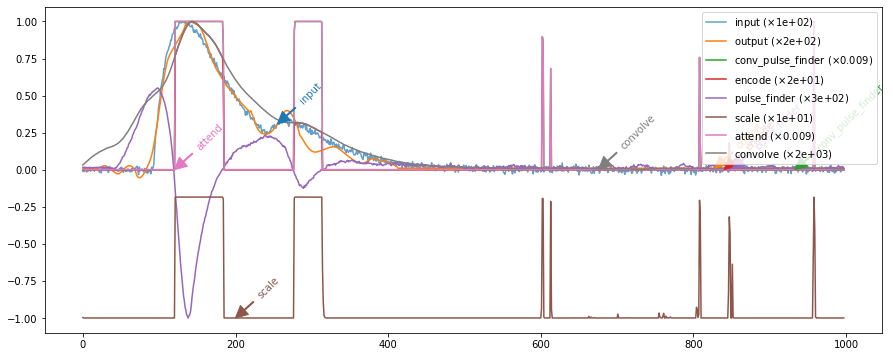

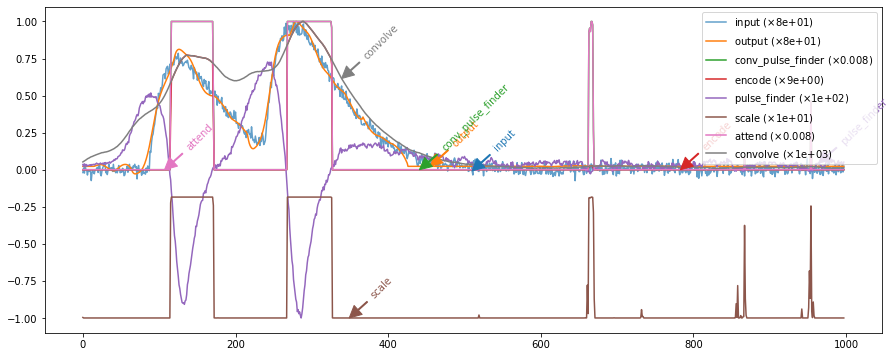

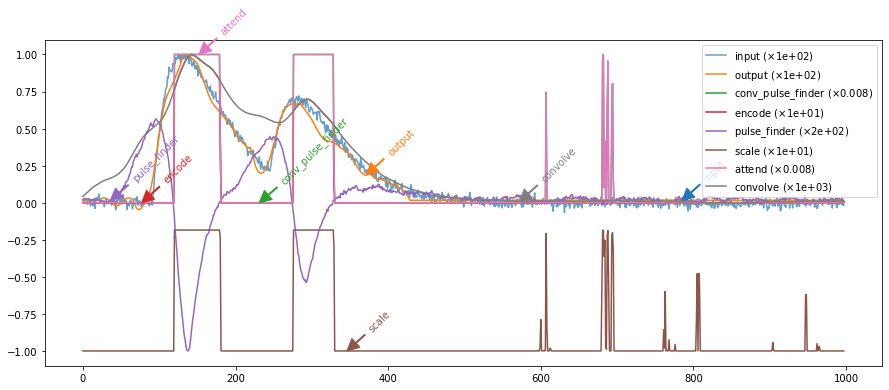

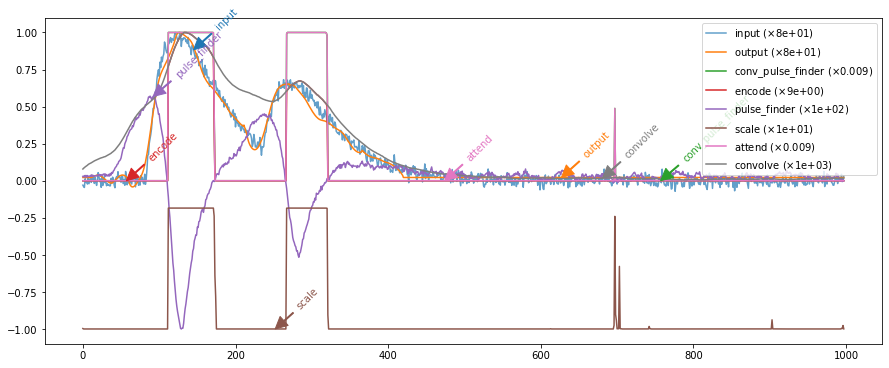

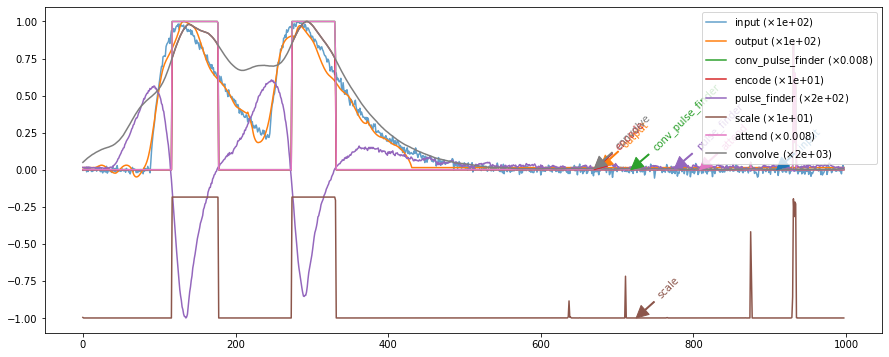

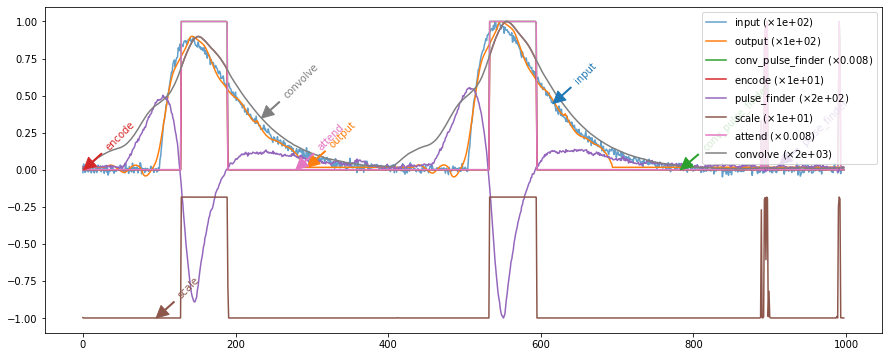

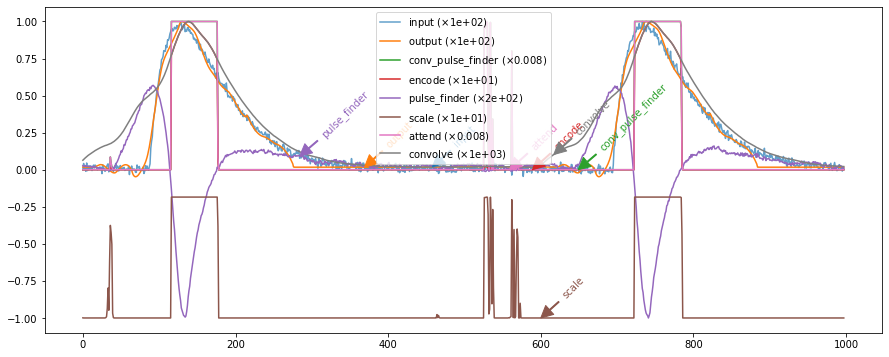

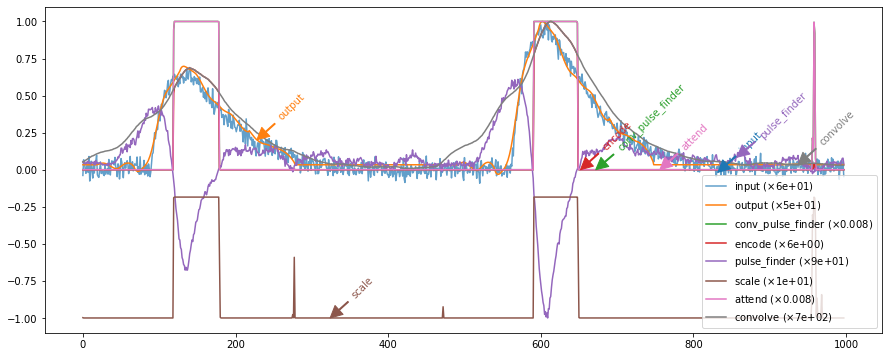

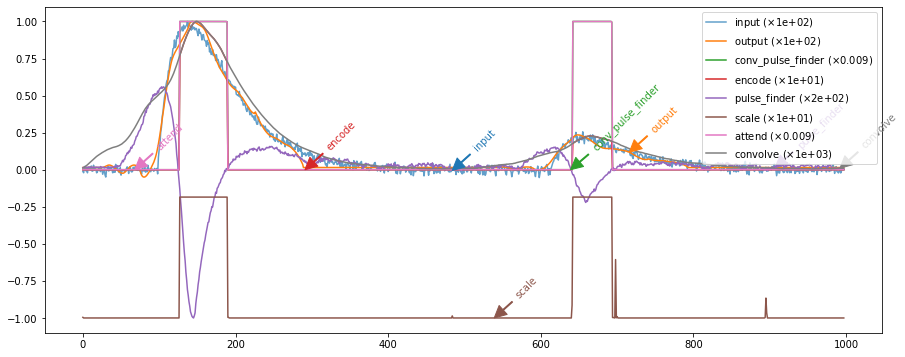

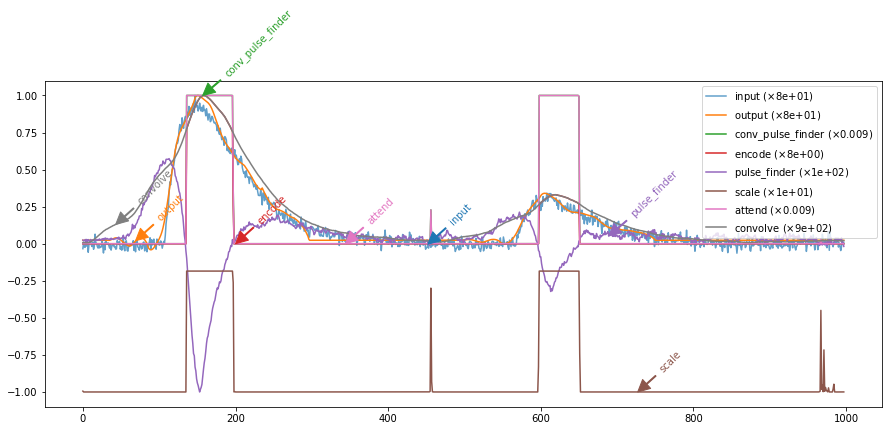

In [124]:
def plot_line(data, label, **kwargs):
  scale = max(data.max(), -data.min())
  lines = plt.plot(data / scale, label=f"{label} ($\\times${scale:.01})", **kwargs)
  x = np.random.randint(len(data))
  y = data[x] / scale
  color = lines[0].get_color()
  plt.annotate(label, (x,y), xycoords="data", textcoords="offset points", xytext=(20,20), arrowprops=dict(width=1, color=color), color=color , rotation=45)
  

def plot_prediction(model, input):
  output = model(input.to(device))
  plot_line(input[0], label="input", alpha=0.7)
  plot_line(output[0].detach().cpu().numpy(), label="output")
  for i in ['conv_pulse_finder', 'encode', 'pulse_finder', 'scale', 'attend', 'convolve' ]:
  #for i in ['convolve', 'pulse_finder', 'combine', 'scale', 'conv_pulse_finder', 'soft_max', 'attend', 'encode', 'reconstruct']:
    plot_line(activations[i][0].cpu(), label=i)
  plt.legend()
  #plt.yscale("log")

close_time = np.random.choice(np.where(truth[1][:, 1] < 250)[0], 5)
far_time = np.random.choice(np.where(truth[1][:, 1] > 500)[0], 5)
choices = np.concatenate((close_time, far_time))
for i in choices: #np.random.randint(len(data), size=10):
  plt.figure(figsize=(15,6))
  plot_prediction(model, ds[i][0])

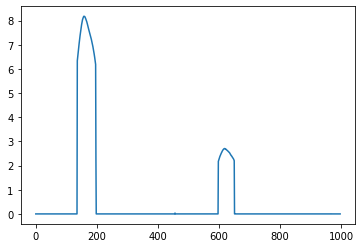

In [125]:
plt.plot(activations["encode"][0].cpu().numpy())
#plt.yscale("log")


In [118]:
for n, p in model.named_parameters():
  print(n, p)

convolve.weight Parameter containing:
tensor([[[-3.9160e-02, -2.6216e-02, -2.6458e-03,  7.9814e-03,  7.9413e-03,
           5.9390e-03,  5.5034e-03,  6.0896e-03,  6.8159e-03,  8.0089e-03,
           8.6714e-03,  9.0219e-03,  8.6879e-03,  8.8126e-03,  8.3448e-03,
           8.1534e-03,  1.0094e-02,  1.1117e-02,  1.4374e-02,  1.7748e-02,
           2.0258e-02,  2.3039e-02,  2.1784e-02,  1.4118e-02, -2.0735e-03,
          -3.0850e-02, -6.3055e-02, -8.1885e-02, -7.5972e-02, -5.3761e-02,
          -2.6489e-02, -4.0988e-03,  8.7217e-03,  1.5964e-02,  1.6058e-02,
           1.4673e-02,  8.1031e-03,  6.1324e-03,  5.6039e-03,  1.0961e-03,
           1.2695e-04,  6.2858e-03, -5.1123e-04,  2.7607e-03,  5.6027e-03,
           3.0434e-03,  6.1590e-04,  4.2955e-03,  6.8045e-04, -3.1279e-03,
           9.4226e-03,  7.2992e-03,  1.9252e-02,  1.2548e-02,  1.3802e-02,
           1.6957e-02,  1.2236e-02,  1.5904e-02,  1.1866e-02,  8.6263e-03,
           1.0158e-02,  8.6222e-03,  1.2279e-02,  1.0085e-02, 

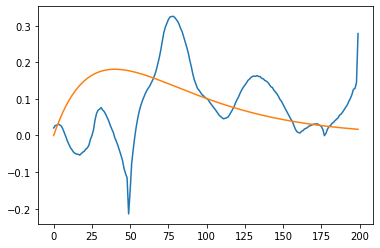

In [126]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)
expected = wps.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected)

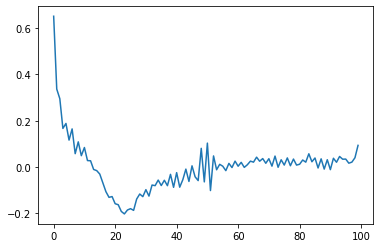

In [127]:
learnt = model.get_parameter("attend.conv_pulse_finder.pulse_finder.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)

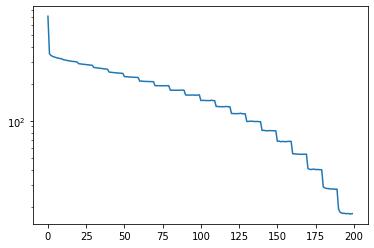

In [128]:
plt.plot(train_test_runner.train_loss);
plt.yscale("log")